<a href="https://colab.research.google.com/github/Jae2Wook/Machine-Learning-Class/blob/main/Copy_of_starter_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip

# Combine the two traning directories
!echo "Mergining training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip

!echo "Data ready."

Unzipping files...
replace training1/00009/00043_00015.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace training1/00009/00004_00018.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace training2/00031/00004_00018.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace test/04354.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Mergining training data...


In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import PIL
import tensorflow as tf
import seaborn as sns
import keras
import datetime
import pathlib

from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models


In [ ]:
# Create an image training dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory

# We're using keras' image_dataset_from_directory method to load our image data.
# See (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation. 


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
training_data = image_dataset_from_directory(training_dir, validation_split=.2, subset='training', seed=42, image_size=image_size)
validation_data = image_dataset_from_directory(training_dir, validation_split=.2, subset='validation', seed=42, image_size=image_size)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


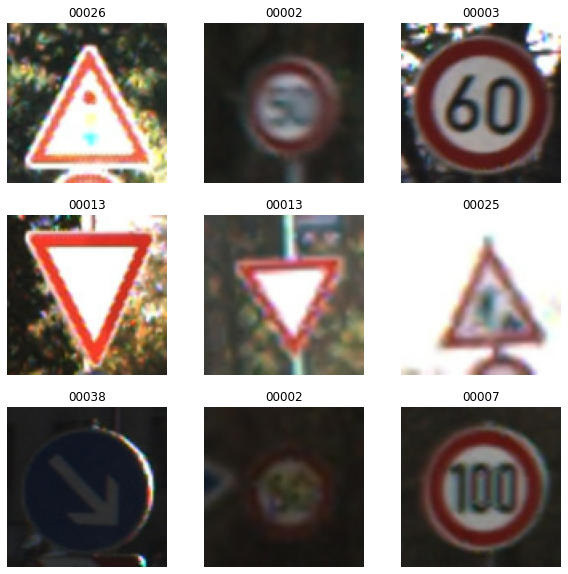

In [ ]:
import matplotlib.pyplot as plt

# View first 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in training_data.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(training_data.class_names[labels[i]])
    plt.axis("off")

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.3),
  layers.experimental.preprocessing.RandomCrop(100, 100),
  layers.experimental.preprocessing.RandomZoom(.5, .2),
  layers.experimental.preprocessing.RandomContrast(0.2, 0.7)
])

build model

In [ ]:
model = tf.keras.Sequential([data_augmentation,
                             #first convolutional layer
                             layers.Conv2D(16, (3,3), activation = 'relu', padding = "same", input_shape = (100, 100, 3)),
                             layers.BatchNormalization(),
                             layers.Conv2D(16, (3,3), activation = 'relu', padding = "same"),
                             layers.BatchNormalization(),
                             layers.MaxPool2D(pool_size = 2, strides = 2),
                             layers.BatchNormalization(),
                             # 2nd convolutional layer
                             layers.Conv2D(32, (3,3),  activation = "relu", padding = "same"),
                             layers.BatchNormalization(),
                             layers.Conv2D(32, (3,3), activation = 'relu', padding = "same"),
                             layers.BatchNormalization(),
                             layers.MaxPool2D(pool_size = 2, strides = 2),
                             layers.BatchNormalization(),
                             # 3rd convolutional layer
                             layers.Conv2D(64, (3,3), activation = 'relu'),
                             layers.BatchNormalization(),
                             layers.Conv2D(64, (3,3), activation = "relu"),
                             layers.BatchNormalization(),
                             layers.MaxPool2D(pool_size = 2, strides = 2),
                             layers.BatchNormalization(),
                             # fully connected classifier
                             layers.Flatten(),
                             layers.Dense(2048, activation = 'relu'),
                             layers.Dense(1024, activation = 'relu'),
                             layers.Dense(128, activation = 'relu'),
                             layers.Dense(43, activation = "softmax")
])

In [ ]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

epochs = 25
history = model.fit(training_data, batch_size = 64, epochs = epochs, validation_data = validation_data)

Epoch 1/25
981/981 [==============================] - 45s 41ms/step - loss: 2.3913 - accuracy: 0.3327 - val_loss: 1.1664 - val_accuracy: 0.6453
Epoch 2/25
981/981 [==============================] - 40s 40ms/step - loss: 0.7029 - accuracy: 0.7727 - val_loss: 0.2629 - val_accuracy: 0.9129
Epoch 3/25
981/981 [==============================] - 40s 40ms/step - loss: 0.3440 - accuracy: 0.8911 - val_loss: 0.2813 - val_accuracy: 0.9138
Epoch 4/25
981/981 [==============================] - 40s 40ms/step - loss: 0.2379 - accuracy: 0.9264 - val_loss: 0.1525 - val_accuracy: 0.9509
Epoch 5/25
981/981 [==============================] - 40s 40ms/step - loss: 0.1837 - accuracy: 0.9444 - val_loss: 0.4334 - val_accuracy: 0.8916
Epoch 6/25
981/981 [==============================] - 40s 40ms/step - loss: 0.1733 - accuracy: 0.9481 - val_loss: 0.0774 - val_accuracy: 0.9753
Epoch 7/25
981/981 [==============================] - 40s 40ms/step - loss: 0.1468 - accuracy: 0.9569 - val_loss: 0.0795 - val_accuracy:

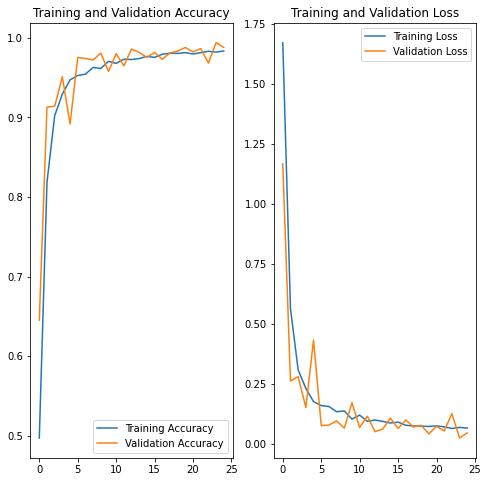

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, acc = model.evaluate(validation_data)
print("Accuracy", acc)

246/246 [==============================] - 6s 23ms/step - loss: 0.0472 - accuracy: 0.9878
Accuracy 0.9877566695213318


Make predictions

In [ ]:
def predict_an_image(mode, file_path):
  # Load the image
  img = keras.preprocessing.image.load_img(file_path, target_size = (100,100))

  # Get the image into the shape we need for our network
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Predict the class
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  return np.argmax(score)

In [ ]:
# Loop through all images in our test directory and make
# a prediction

testdir = pathlib.Path('/content/test')
image_paths = list(testdir.glob('*.jpg'))
prediction_list = []
image_file_name = []
for image_path in image_paths:
  prediction = predict_an_image(model, str(image_path))
  prediction_list.append(prediction)
  image_name = str(image_path)
  image_name = image_name.split('/')[3]
  image_file_name.append(image_name)
  print(image_name, prediction)

Streaming output truncated to the last 5000 lines.
05013.jpg 18
09520.jpg 17
08561.jpg 23
11582.jpg 16
08777.jpg 38
09657.jpg 5
04519.jpg 7
06049.jpg 12
04552.jpg 2
07043.jpg 13
04199.jpg 12
09770.jpg 12
09181.jpg 2
01693.jpg 17
01832.jpg 5
11088.jpg 8
01736.jpg 4
09858.jpg 2
11973.jpg 8
00670.jpg 15
02031.jpg 7
04088.jpg 28
06387.jpg 2
03147.jpg 1
08682.jpg 31
05672.jpg 4
12436.jpg 40
06364.jpg 38
05782.jpg 12
03799.jpg 30
09134.jpg 13
05058.jpg 9
10906.jpg 38
12053.jpg 20
10730.jpg 5
04193.jpg 18
10666.jpg 5
10275.jpg 1
06193.jpg 10
09233.jpg 42
03564.jpg 27
08068.jpg 25
11266.jpg 20
00355.jpg 40
10293.jpg 33
09271.jpg 1
04401.jpg 15
05831.jpg 8
01366.jpg 12
03375.jpg 13
11767.jpg 5
00559.jpg 24
06580.jpg 8
09538.jpg 1
06733.jpg 2
12297.jpg 31
09331.jpg 7
10761.jpg 31
04844.jpg 12
09579.jpg 18
00410.jpg 25
01194.jpg 7
06535.jpg 2
05370.jpg 5
07238.jpg 1
09889.jpg 33
09867.jpg 14
12267.jpg 5
00469.jpg 7
12197.jpg 38
05238.jpg 38
07902.jpg 4
03999.jpg 4
07563.jpg 25
02784.jpg 38
10999.

In [ ]:
combined = list(zip(image_file_name, prediction_list))  
results = pd.DataFrame(combined, columns = ['Filename', 'Prediction']) 
results.head(7)

,Filename,Prediction
0,04287.jpg,17
1,07212.jpg,8
2,01786.jpg,31
3,02194.jpg,5
4,04949.jpg,13
5,01731.jpg,33
6,06404.jpg,7


In [ ]:
test_key = pd.read_csv("/content/test_classes.csv")
test_key.Filename.count() # 12,630
test_key.head(7)

,Filename,ClassId
0,00000.jpg,16
1,00001.jpg,1
2,00002.jpg,38
3,00003.jpg,33
4,00004.jpg,11
5,00005.jpg,38
6,00006.jpg,18


In [ ]:
test_key = test_key.set_index('Filename').join(results.set_index('Filename'))
test_key.head(7)

,ClassId,Prediction
Filename,,
00000.jpg,16,16
00001.jpg,1,1
00002.jpg,38,38
00003.jpg,33,33
00004.jpg,11,11
00005.jpg,38,38
00006.jpg,18,18


In [ ]:
test_key['Correct'] = test_key.ClassId == test_key.Prediction
test_key['Correct'].value_counts()

True     12020
False      610
Name: Correct, dtype: int64

In [ ]:
test_key.head(3)

,ClassId,Prediction,Correct
Filename,,,
00000.jpg,16,16,True
00001.jpg,1,1,True
00002.jpg,38,38,True


In [ ]:
correct = len(test_key[test_key["Correct"]==True])

In [ ]:
accuracy = correct / len(test_key.index)
accuracy

0.9517022961203484

Find the False

In [ ]:
Fals = test_key[test_key["Correct"]!=True]
Fals.head(3)

,ClassId,Prediction,Correct
Filename,,,
00049.jpg,8,1,False
00050.jpg,25,28,False
00072.jpg,30,11,False


No handles with labels found to put in legend.


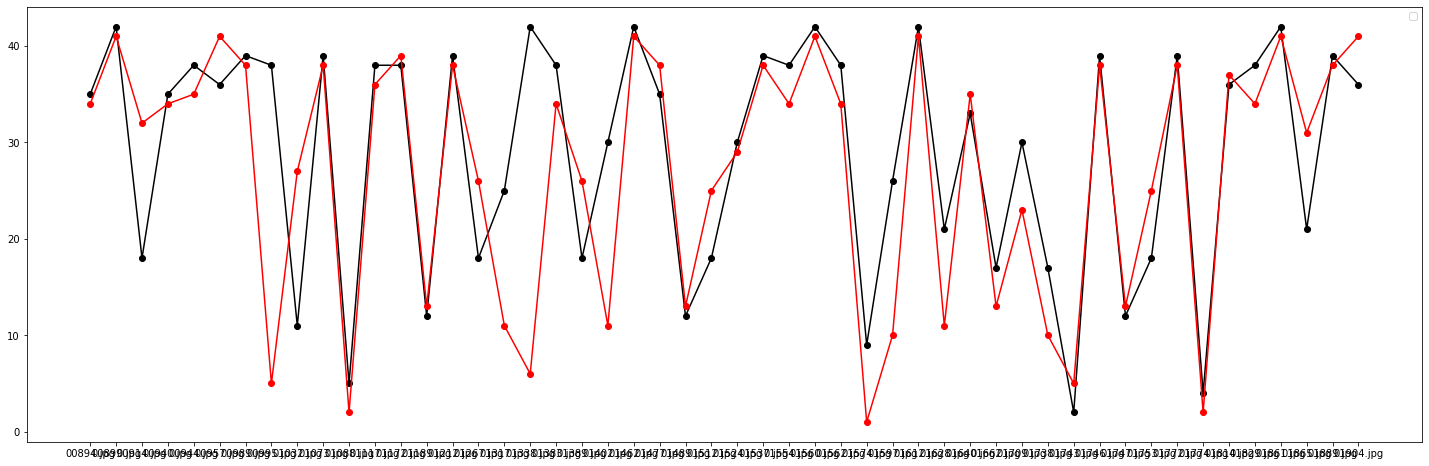

In [ ]:
Fals_sub = Fals[40:90]

plt.figure(figsize = (25, 8))

plt.plot(Fals_sub.ClassId, marker='o', color='black')
plt.plot(Fals_sub.Prediction, marker='o', color='red')
plt.legend()
plt.show()

In [ ]:
### Save the Model into Format ready for Apple CoreML ###
import coremltools as ct
from keras.models import load_model

# Pass in `tf.keras.Model` to the Unified Conversion API
mlmodel = ct.convert(model)

# or save the keras model in SavedModel directory format and then convert
model.save('tf_keras_model')
mlmodel = ct.convert('tf_keras_model')

# or save the keras model in HDF5 format and then convert
model.save('tf_keras_model.h5')
mlmodel = ct.convert('tf_keras_model.h5')